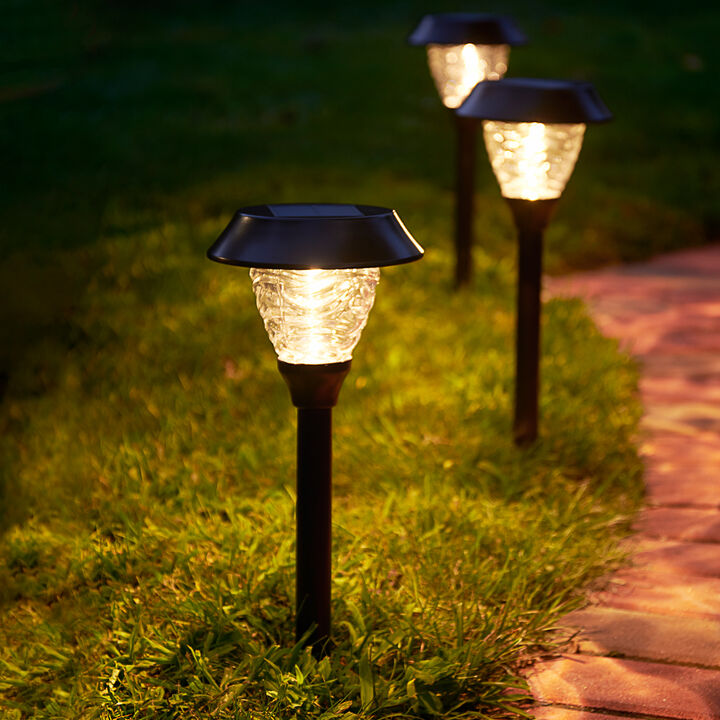

In [ ]:
import requests
import json
import time
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error
import matplotlib.pyplot as plt

In [2]:
"""Extract Data from Excel which includes detail information of solar lights product"""
raw_df = pd.read_excel ('Solar_lights.xlsx',sheet_name ="solar_lights_clean" )

In [3]:
raw_df.head()

,Date,ASIN,SKU,品牌,商品标题,商品主图,父体,ASIN+,类目,BSR排名,...,BuyBox卖家国籍,BuyBox类型,Best Seller标识,Amazon's Choice,New Release标识,A+页面,视频介绍,重量,体积,最近更新
0,07/01/19,7805293678,NaN,Florals,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",https://images-na.ssl-images-amazon.com/images...,NaN,7805293678,Home & Kitchen:Home Décor:Artificial Plants & ...,750524.0,...,US,FBM,NaN,NaN,NaN,NaN,NaN,1 pounds,12 x 8 x 24 inches,2019-11-30
1,08/01/19,7805293678,NaN,Florals,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",https://images-na.ssl-images-amazon.com/images...,NaN,7805293678,Home & Kitchen:Home Décor:Artificial Plants & ...,750524.0,...,US,FBM,NaN,NaN,NaN,NaN,NaN,1 pounds,12 x 8 x 24 inches,2019-11-30
2,09/01/19,7805293678,NaN,Florals,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",https://images-na.ssl-images-amazon.com/images...,NaN,7805293678,Home & Kitchen:Home Décor:Artificial Plants & ...,750524.0,...,US,FBM,NaN,NaN,NaN,NaN,NaN,1 pounds,12 x 8 x 24 inches,2019-11-30
3,07/01/19,B000BRCL0O,NaN,Progressive International,Progressive Dynamics PD308 Clear Optic Solar-S...,https://images-na.ssl-images-amazon.com/images...,NaN,B000BRCL0O,Automotive:Motorcycle & Powersports:Protective...,460368.0,...,US,FBM,NaN,NaN,NaN,NaN,NaN,0.1 pounds,7.5 x 0.1 x 1.1 inches,2020-05-26
4,10/01/19,B000BRCL0O,NaN,Progressive International,Progressive Dynamics PD308 Clear Optic Solar-S...,https://images-na.ssl-images-amazon.com/images...,NaN,B000BRCL0O,Automotive:Motorcycle & Powersports:Protective...,220107.0,...,US,FBM,NaN,NaN,NaN,NaN,NaN,1.6 ounces,7.5 x 0.1 x 1.1 inches,2020-05-18


In [9]:
"""Take the column we need and rename the column into English Version"""

df = raw_df[["Date","ASIN+","商品标题","品牌","类目","月销量","月销售额($)","价格($)","评分数","评分","重量","体积"]]
df.dropna(subset = ["Date","ASIN+","商品标题","品牌","类目","月销量","月销售额($)",\
                    "价格($)","评分数","评分","重量","体积"], inplace=True)
df = df.rename(columns={"品牌":"brand","月销量": "monthly_sales_number", "月销售额($)": "monthly_sales_revenue",\
                        "商品标题":"product_title","类目":"category","价格($)":"price($)","评分数":"numbers_of_rate",\
                        "评分":"rate","重量":"Weight","体积":"Volumn"})

df.head()

<ipython-input-9-310de35c125b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ["Date","ASIN+","商品标题","品牌","类目","月销量","月销售额($)",\


,Date,ASIN+,product_title,brand,category,monthly_sales_number,monthly_sales_revenue,price($),numbers_of_rate,rate,Weight,Volumn
0,07/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,6.0,107.94,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches
1,08/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,4.0,71.96,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches
2,09/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,4.0,71.96,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches
3,07/01/19,B000BRCL0O,Progressive Dynamics PD308 Clear Optic Solar-S...,Progressive International,Automotive:Motorcycle & Powersports:Protective...,53.0,185.50,3.50,15.0,3.5,0.1 pounds,7.5 x 0.1 x 1.1 inches
4,10/01/19,B000BRCL0O,Progressive Dynamics PD308 Clear Optic Solar-S...,Progressive International,Automotive:Motorcycle & Powersports:Protective...,45.0,306.90,6.94,17.0,3.4,1.6 ounces,7.5 x 0.1 x 1.1 inches


In [10]:
"""Change the weight and volumn into the format we want"""
"""Change pounds into onces and change volumn into product of three dimension"""

def weight_replace(row):
    if row["Weight"][-3:] == "nds":
        return float(row["Weight"][:-6])*16
    else:
        return float(row['Weight'][:-6])
    
def volumn_replace(row):
    check = 0
    if row["Volumn"][-3:] == "hes":
        volumn = row["Volumn"][:-6]
    else:
        volumn = row["Volumn"][:-8]  
        check = 1
    volumn = volumn.split("x")
    result = 1
    for i in volumn:
        i = i.replace(",","")
        result *= float(i)
        if check == 1:
            result *= (0.91**3)
    return result


In [11]:
df["new_weight"] = df.apply(lambda row : weight_replace(row), axis = 1)
df["new_volumn"] = df.apply(lambda row : volumn_replace(row), axis = 1)
df.head()

,Date,ASIN+,product_title,brand,category,monthly_sales_number,monthly_sales_revenue,price($),numbers_of_rate,rate,Weight,Volumn,new_weight,new_volumn
0,07/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,6.0,107.94,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches,16.0,2304.000
1,08/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,4.0,71.96,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches,16.0,2304.000
2,09/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,4.0,71.96,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches,16.0,2304.000
3,07/01/19,B000BRCL0O,Progressive Dynamics PD308 Clear Optic Solar-S...,Progressive International,Automotive:Motorcycle & Powersports:Protective...,53.0,185.50,3.50,15.0,3.5,0.1 pounds,7.5 x 0.1 x 1.1 inches,1.6,0.825
4,10/01/19,B000BRCL0O,Progressive Dynamics PD308 Clear Optic Solar-S...,Progressive International,Automotive:Motorcycle & Powersports:Protective...,45.0,306.90,6.94,17.0,3.4,1.6 ounces,7.5 x 0.1 x 1.1 inches,1.6,0.825


In [113]:
"""Connect to mysql server and create a table for our solar light data"""
try:
    connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password="pass",
        database="my_project"
        )

    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("CREATE TABLE solar_light (Date VARCHAR(255) ,\
                       ASIN VARCHAR(255) ,\
                       product_title VARCHAR(255),\
                       brand VARCHAR(255) ,\
                       category VARCHAR(255),\
                       monthly_sales_number double,\
                       monthly_sales_revenue double,\
                       price double ,\
                       numbers_of_rate double ,\
                       rate double ,\
                       weight VARCHAR(255) ,\
                       volumn VARCHAR(255),\
                       new_weight double ,\
                       new_volumn double)")
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("Your connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.25
Your connected to database:  ('my_project',)
MySQL connection is closed


In [21]:
"""Upload all the data from python to mysql server"""

def insert_value_to_solarlight(value):
    try:
        connection = mysql.connector.connect(
            host="localhost",
            user="root",
            password="pass",
            database="my_project"
            )


        if connection.is_connected():
            db_Info = connection.get_server_info()
      
            cursor = connection.cursor()


            sql = """INSERT INTO solar_light (Date, ASIN, product_title, brand, category,\
            monthly_sales_number, monthly_sales_revenue, price, numbers_of_rate, rate, weight, volumn, new_weight, new_volumn)\
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
            cursor.execute(sql, value)
            connection.commit()
            

    except mysql.connector.Error as error:
        pass

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            

In [118]:
for i, row in df.iterrows():
    insert_value_to_solarlight(tuple(row))


In [62]:
'''Once we have data in mysql server, we can read data from mysql'''

try:   
    connection = mysql.connector.connect(
            host="localhost",
            user="root",
            password="pass",
            database="my_project"
            )

    cursor = connection.cursor()

    cursor.execute('SELECT convert(DATETIME,Date,103) from solar_light')

    table_rows = cursor.fetchall()

    df_sql = pd.DataFrame(table_rows)
    df_sql.columns = cursor.column_names
    
except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Error while connecting to MySQL 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near ',103) from solar_light' at line 1
MySQL connection is closed


In [60]:
df_sql

,Date,ASIN,product_title,brand,category,monthly_sales_number,monthly_sales_revenue,price,numbers_of_rate,rate,weight,volumn,new_weight,new_volumn
0,07/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,6.0,107.94,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches,16.00,2304.00000
1,08/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,4.0,71.96,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches,16.00,2304.00000
2,09/01/19,7805293678,"Solar Yellow Rose Flower Lights , Lamp, Solar ...",Florals,Home & Kitchen:Home Décor:Artificial Plants & ...,4.0,71.96,17.99,1.0,5.0,1 pounds,12 x 8 x 24 inches,16.00,2304.00000
3,07/01/19,B000BRCL0O,Progressive Dynamics PD308 Clear Optic Solar-S...,Progressive International,Automotive:Motorcycle & Powersports:Protective...,53.0,185.50,3.50,15.0,3.5,0.1 pounds,7.5 x 0.1 x 1.1 inches,1.60,0.82500
4,10/01/19,B000BRCL0O,Progressive Dynamics PD308 Clear Optic Solar-S...,Progressive International,Automotive:Motorcycle & Powersports:Protective...,45.0,306.90,6.94,17.0,3.4,1.6 ounces,7.5 x 0.1 x 1.1 inches,1.60,0.82500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159391,11/01/20,B09311PDDW,"Solar Lights Outdoor, Aootek 2-in-1 Adjustable...",Aootek,Tools & Home Improvement:Lighting & Ceiling Fa...,0.0,0.00,29.99,76.0,4.9,2.23 pounds,11 x 5.9 x 3.9 inches,35.68,253.11000
159392,12/01/20,B09311PDDW,"Solar Lights Outdoor, Aootek 2-in-1 Adjustable...",Aootek,Tools & Home Improvement:Lighting & Ceiling Fa...,0.0,0.00,29.99,76.0,4.9,2.23 pounds,11 x 5.9 x 3.9 inches,35.68,253.11000
159393,02/01/21,B09311PDDW,"Solar Lights Outdoor, Aootek 2-in-1 Adjustable...",Aootek,Tools & Home Improvement:Lighting & Ceiling Fa...,0.0,0.00,29.99,76.0,4.9,2.23 pounds,11 x 5.9 x 3.9 inches,35.68,253.11000
159394,03/01/21,B09311PDDW,"Solar Lights Outdoor, Aootek 2-in-1 Adjustable...",Aootek,Tools & Home Improvement:Lighting & Ceiling Fa...,0.0,0.00,29.99,76.0,4.9,2.23 pounds,11 x 5.9 x 3.9 inches,35.68,253.11000


In [64]:
"""group the data by Date and sort the data based on year and month"""

by_date =  df_sql.groupby('Date').sum()
by_date = by_date.sort_index(key = lambda col: col.map(lambda x: (x[-2:],x[:2])) )

by_date

,monthly_sales_number,monthly_sales_revenue,price,numbers_of_rate,rate,new_weight,new_volumn
Date,,,,,,,
01/01/19,176465.0,5.424376e+06,40599.18,223103.0,4629.5,34862.306,5.435460e+05
02/01/19,238205.0,7.148969e+06,86891.06,633634.0,9380.6,95043.182,2.236236e+07
03/01/19,301920.0,9.180190e+06,84334.57,364120.0,9152.9,92631.910,2.153072e+07
04/01/19,809683.0,2.443216e+07,207994.92,577075.0,26529.2,227154.660,7.754829e+07
05/01/19,1109492.0,3.358150e+07,206730.60,609740.0,26310.9,219783.776,7.415170e+07
06/01/19,951585.0,2.866752e+07,223258.15,661903.0,28716.4,232387.744,7.656317e+07
07/01/19,1035494.0,3.335683e+07,282376.26,596095.0,39034.3,304745.021,7.142927e+07
08/01/19,945028.0,3.051043e+07,290661.29,646100.0,40184.1,311861.146,8.045649e+07
09/01/19,974688.0,3.112749e+07,293687.27,636239.0,39602.0,316976.807,8.538883e+07


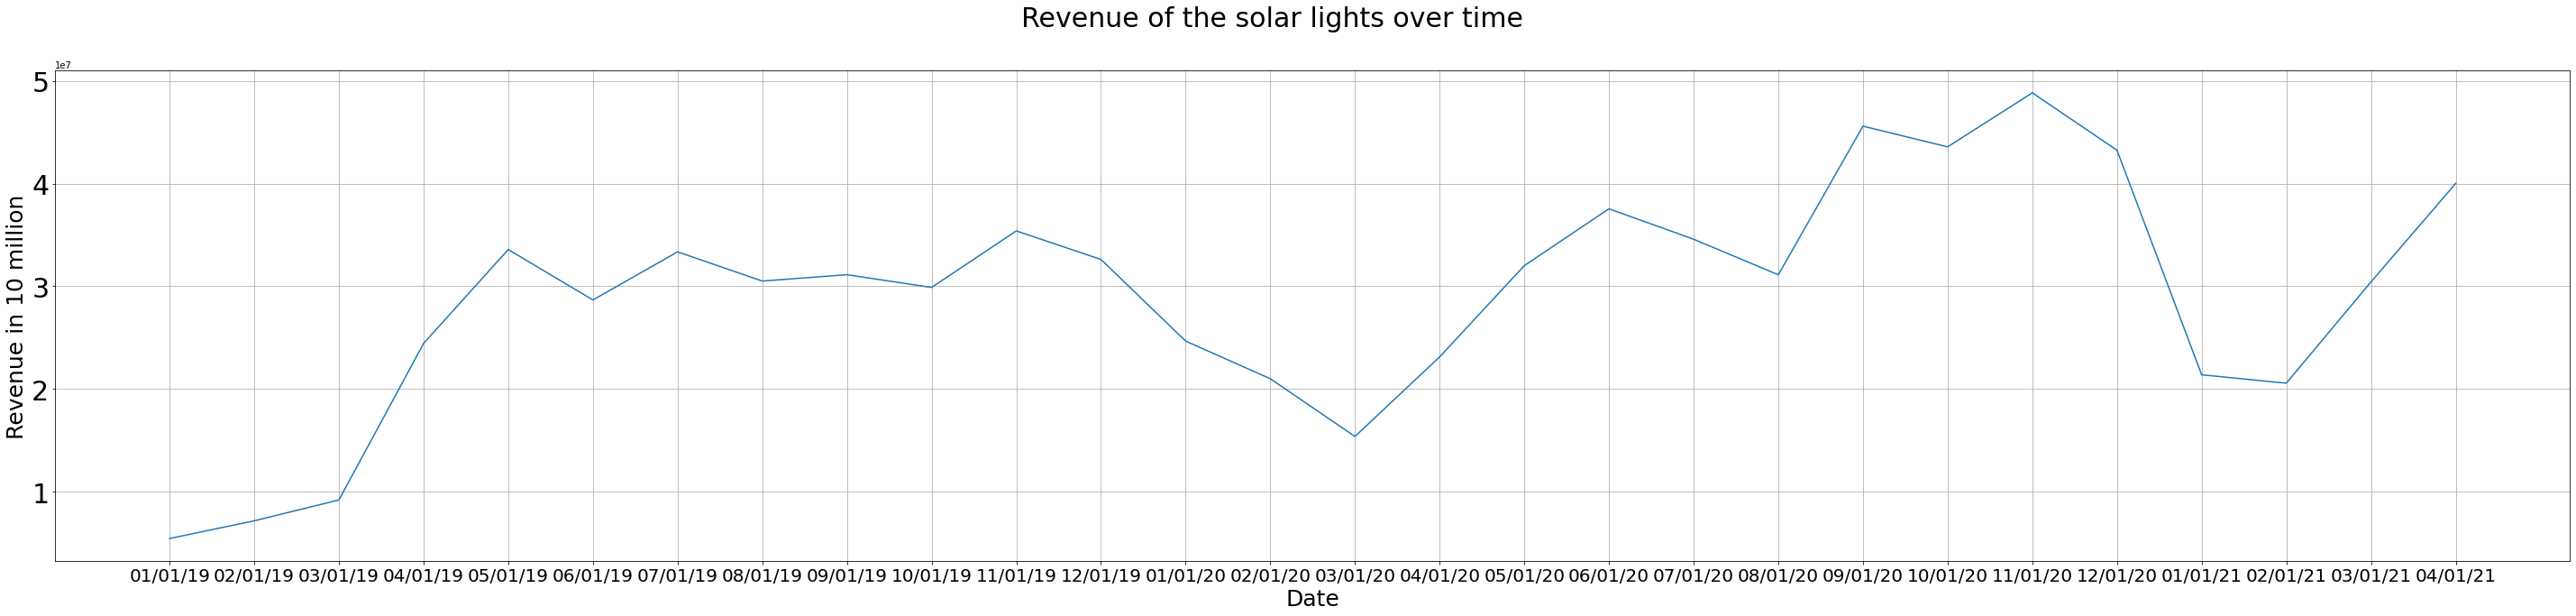

In [84]:
"""plot the figure showing the trend of the solar light sales over time"""

revenue = by_date["monthly_sales_revenue"]
plt.figure(figsize=(50,10))
plt.plot(revenue)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Revenue in 10 million', fontsize = 25)
plt.suptitle('Revenue of the solar lights over time', fontsize = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

In [89]:
"""Group by category and plot the figure showing the top 10 category"""

by_category =  df_sql.groupby('category').sum()
by_category = by_category.sort_values(by = ['monthly_sales_revenue'], ascending = False)
by_category

,monthly_sales_number,monthly_sales_revenue,price,numbers_of_rate,rate,new_weight,new_volumn
category,,,,,,,
Tools & Home Improvement:Lighting & Ceiling Fans:Outdoor Lighting:Landscape Lighting:Path Lights,4630683.0,1.434447e+08,859976.49,3726197.0,115745.5,963014.722,7.342863e+07
Tools & Home Improvement:Lighting & Ceiling Fans:Outdoor Lighting:String Lights,5788024.0,1.368191e+08,692352.75,5235596.0,133340.5,572911.698,1.384174e+07
Tools & Home Improvement:Lighting & Ceiling Fans:Outdoor Lighting:Flood & Security Lights,1965853.0,7.944885e+07,445762.75,2066455.0,38096.1,475281.914,2.999580e+07
Tools & Home Improvement:Lighting & Ceiling Fans:Outdoor Lighting:Landscape Lighting:Spotlights,1857536.0,7.351975e+07,233662.89,1497002.0,27915.4,205723.344,5.893072e+06
Tools & Home Improvement:Lighting & Ceiling Fans:Outdoor Lighting:Porch & Patio Lights:Wall Lights,1642217.0,5.602619e+07,255959.17,2092346.0,35533.4,180950.848,4.990620e+06
...,...,...,...,...,...,...,...
Tools & Home Improvement:Lighting & Ceiling Fans:Novelty Lighting:Black Light Fixtures,0.0,0.000000e+00,39.99,13.0,2.8,32.000,1.200000e-01
Cell Phones & Accessories:Accessories:Photo & Video Accessories:Lens Attachments,117.0,0.000000e+00,0.00,142.0,39.9,36.480,4.133203e+02
"Automotive:Tools & Equipment:Jump Starters, Battery Chargers & Portable Power",51.0,0.000000e+00,0.00,110.0,31.0,840.000,1.020000e+03


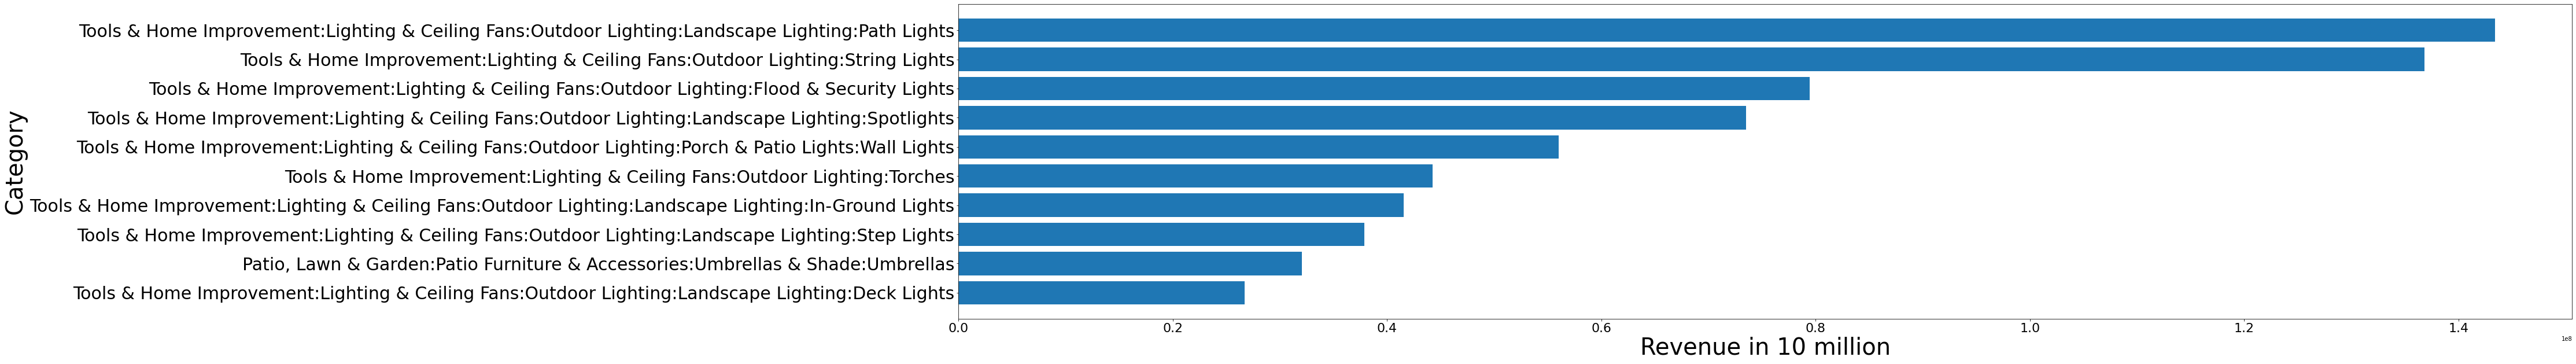

In [133]:
"""Group by the product category and show the top 10 hot-selling product category and show the revenue in bar plot"""
revenue = by_category['monthly_sales_revenue']
revenue = revenue[0:10]
category = revenue.index
plt.figure(figsize=(50,10))
plt.barh(category ,revenue)
plt.xticks(fontsize=22)
plt.yticks(fontsize=30)
plt.gca().invert_yaxis()
plt.xlabel("Revenue in 10 million",fontsize = 40)
plt.ylabel("Category", fontsize = 40)
plt.show()

In [159]:
"""Group by the brand and show the market infiltration rate"""

by_brand = df_sql.pivot_table(columns=['brand'], aggfunc='size').sort_values(ascending=False)
by_brand = by_brand/df_sql.count()[0]
by_brand = by_brand.apply(lambda x: format(x, '.3%'))
by_brand

brand
Exhart            1.016%
LITOM             0.841%
GIGALUMI          0.805%
Sogrand           0.644%
MAGGIFT           0.620%
                   ...  
YXLM              0.001%
Rose's Rustics    0.001%
GL                0.001%
Brand: EcoCity    0.001%
Globle Direct     0.001%
Length: 7081, dtype: object